<h1>Salt Lake City Cyclist & Pedestrian Safety</h1><br>
The state of Utah has published a dataset containing information about car crashes over a period of more than four years covering the entire state. The goal of this project is to examine the data for Salt Lake City proper, and answer two primary questions:

1. Does the frequency distribution of crashes involving cyclists and/or pedestrians track with the distibution of crashes in general for the city of Salt Lake?
2. During what times is the likelihood of a crash involving a cyclist or pedestrian highest?

The data for this project came from the [Utah Open Data Catalog](https://opendata.utah.gov/). This project uses the [State of Utah Crash Data 2015-2019](https://opendata.utah.gov/Public-Safety/State-of-Utah-Crash-Data-2015-2019/7ihm-46s4).

In [ ]:
#import necessary libraries: dplyr, ggplot2, and lubridate
library(dplyr)
library(ggplot2)
library(lubridate)
library(ggthemes)
library(gridExtra)

In [2]:
#define the data types of the colums
col_types <- c('CRASH_DATE' = 'character', 
               'PEDESTRIAN' = 'logical', 
               'BICYCLIST_' = 'logical', 
               'MOTORCYCLE' = 'logical', 
               'IMPROPER_R' = 'logical', 
               'UNRESTRAIN' = 'logical', 
               'DUI' = 'logical', 
               'INTERSECTI' = 'logical', 
               'WILD_ANIMA' = 'logical', 
               'DOMESTIC_A' = 'logical', 
               'OVERTURN_R' = 'logical', 
               'COMMERCIAL' = 'logical', 
               'TEENAGE_DR' = 'logical', 
               'OLDER_DRIV' = 'logical', 
               'NIGHT_DARK' = 'logical', 
               'SINGLE_VEH' = 'logical', 
               'DISTRACTED' = 'logical', 
               'DROWSY_DRI' = 'logical', 
               'ROADWAY_DE' = 'logical')
#import the csv using col_types as the columnClasses
crash <- read.csv("State_of_Utah_Crash_Data_2015-2019.csv", stringsAsFactors = TRUE, colClasses=col_types)

In [3]:
#convert CRASH_DATE column to datetime using format mm/dd/yyyy H:M:S AM/PM
crash$CRASH_DATE <- as.POSIXct(crash$CRASH_DATE, tz = "America/Denver", format = "%m/%d/%Y %I:%M:%S %p")

#create columns that contain the hour, clock time, and calendar day (w/o year) of the crash
crash <- crash %>%
    mutate(crash_hour = hour(CRASH_DATE)) %>%
    mutate(crash_time = strftime(CRASH_DATE, format="%H:%M:%S")) %>%
    mutate(crash_day = strftime(CRASH_DATE, format="%m/%d")) %>%
    mutate(crash_time_15 = crash_hour + ((floor(minute(CRASH_DATE)/15))/4)) %>%
    mutate(crash_time_30 = crash_hour + ((floor(minute(CRASH_DATE)/30))/2))

In [4]:
#define a function that returns which other modes (omode) were involved in the crash
bikeped <- function(bike, ped) {
    if (bike == TRUE & ped == FALSE){
        omode <- "Bike & Car"
    }else if (bike == FALSE & ped == TRUE){
        omode <- "Pedestrian & Car"
    }else if (bike == TRUE & ped == TRUE){
        omode <- "Bike, Pedestrian, & Car"
    }else {
        omode <- "Car Only"
    }
    return (omode)
}

#create a new column in df using bikeped fxn
crash <- crash %>% rowwise %>%
    mutate(modes = bikeped(BICYCLIST_, PEDESTRIAN))

In [5]:
#keep only SLC events
crash_slc <- crash %>%
    filter(CITY == "SALT LAKE CITY")

#plot density function for crashes in SLC, with color asigned by modes involved
density <- ggplot(crash_slc, aes(x = crash_time_30, color = modes))+
    geom_density(size = 1.5, kernel = 'gaussian')+
    scale_x_continuous(breaks = seq(0, 24, by = 6))+
    labs(title = "Distribution of Crash Types by Hour")+
    xlab("crash hour")+
    ylab("density")+
    theme_few()+
    theme(
        plot.title = element_text(size = 14, hjust = 0.5),
        legend.position = "none"
    )


In [6]:
#use a stacked bar chart to show the relative frequencies of the various modes in crashes
pie <- ggplot(crash_slc, aes(x='', y=modes, fill=modes))+
    geom_bar(width = 1, stat = "identity")+
    theme_tufte()+
    coord_polar("y", start=0)+
    theme_few()+
    labs(title = "Absolute Distribution")+
    theme(
        axis.text.x = element_blank(),
        axis.title = element_blank(),
        rect = element_blank(),
        legend.position = "bottom",
        legend.direction = "vertical",
        plot.title = element_text(size = 14, hjust = 0.5),
        )

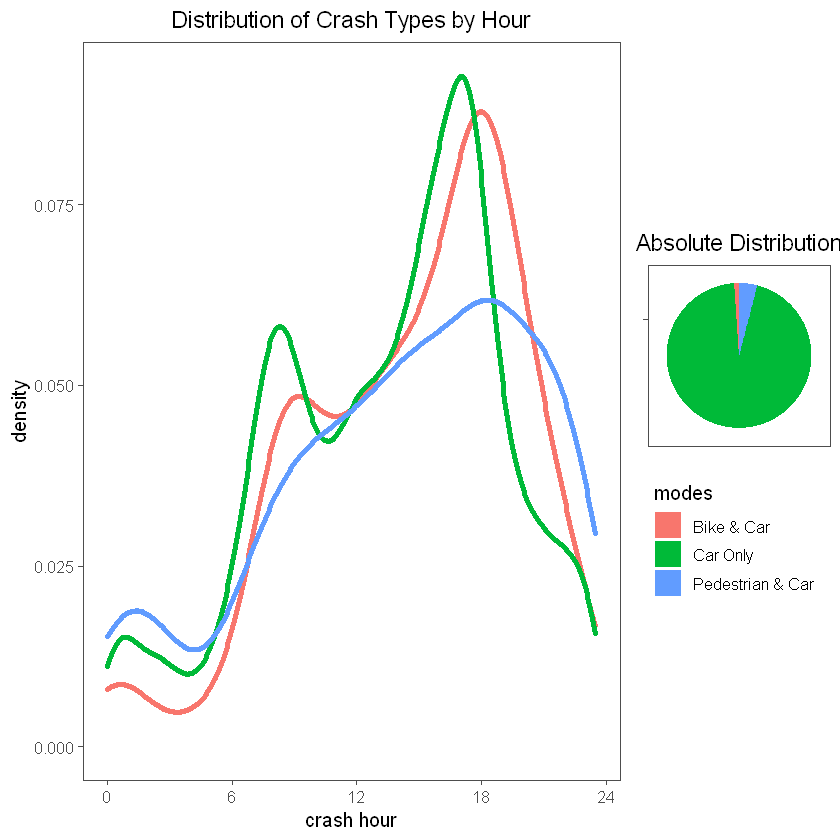

In [7]:
multiplot <- grid.arrange(density, pie, widths = c(3, 1))

ggsave("crash_multi.png", multiplot, height = 6, width = 12)

In [8]:
#create df only containing crashes that involve a bike or a ped, called crash_cycleped
crash_slc_cycleped <- crash_slc %>%
    filter(BICYCLIST_ == TRUE | PEDESTRIAN == TRUE)

#count the number of crashes involving a bike or ped that occur for each hour
cycleped_hourly_count <- crash_slc_cycleped %>%
    count(crash_hour) %>%
    rename(cycleped_n = n)

#count the total number of crashes that occur in each hour, and drop the hour
total_hourly_count <- crash_slc %>%
    count(crash_hour) %>%
    rename(total_n = n) %>%
    select(total_n)

#combine those data frames together into one
combined_count <- cbind(cycleped_hourly_count, total_hourly_count)

#create a new column that shows the percentage of crashes that involve a bike or ped
combined_count <- combined_count %>%
    mutate(cycleped_pct = cycleped_n / total_n * 100)

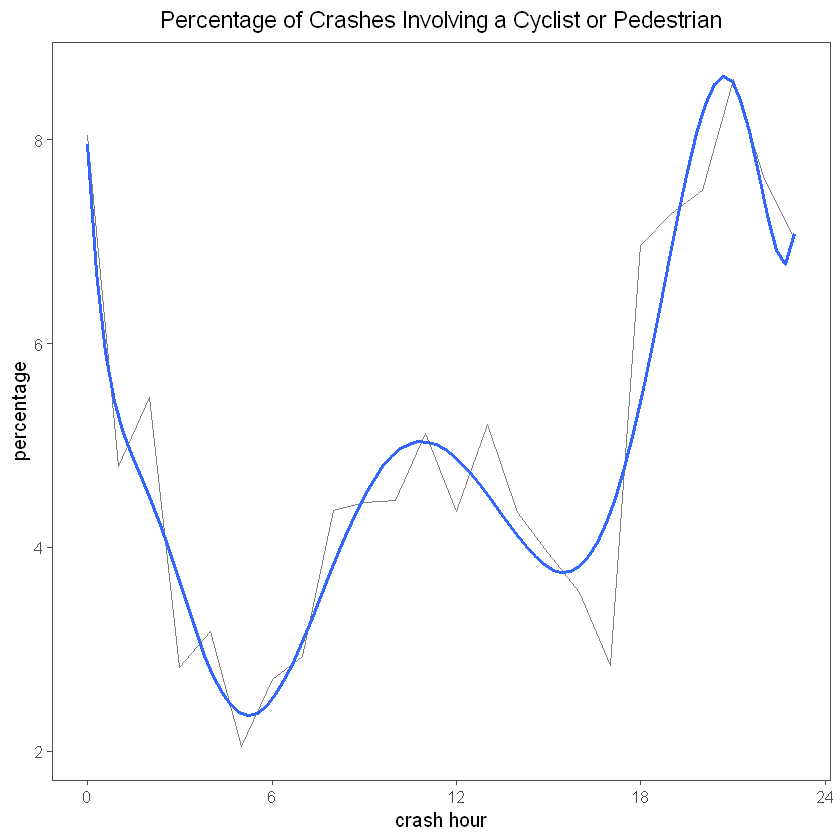

In [10]:
#plot the percentage of bike/ped crashes over the day
ggplot(combined_count, aes(x = crash_hour, y = cycleped_pct))+
    geom_line(alpha = 0.5)+
    stat_smooth(aes(x = crash_hour, y = cycleped_pct), method = lm, formula = y ~ poly(x, 10), se = FALSE)+ 
#    geom_smooth(formula = y ~ poly(x))
    scale_x_continuous(breaks = seq(0, 24, by = 6))+
    labs(title = "Percentage of Crashes Involving a Cyclist or Pedestrian")+
    xlab("crash hour")+
    ylab("percentage")+
    theme_few()+
    theme(
        plot.title = element_text(size = 14, hjust = 0.5)
    )

ggsave("bikeped_freq.png", height = 6, width = 6)